In [8]:
%run ../scripts/imports.py

Succesfully imported libraries and modules



## Loading patients

In [7]:
with open("../path_data.txt") as f:
    data_dir = f.readline()
    
# p1 = load_patient(1, data_dir)
# p2 = load_patient(2, data_dir)
# p3 = load_patient(3, data_dir)
# p4 = load_patient(4, data_dir)
# p5 = load_patient(5, data_dir)
# p6 = load_patient(6, data_dir)
# p7 = load_patient(7, data_dir)
# p8 = load_patient(8, data_dir)
p9 = load_patient(9, data_dir)

Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient9


## Implemented functions

### Matrix norm

In [4]:
def compute_matrix_norm(matrix, norm='p', p=2):
    if norm == 'max':
        return np.max(np.max(matrix))
    if norm == 'p':
        return np.sum(np.sum(matrix ** p)) ** (1/p)

### Bipartate Graph

#### Get BiGraph

In [3]:
def get_bigraph(patient, 
                condition, 
                signficance=0.01, 
                norm_type='p', 
                p=0.9, 
                norm_threshold=2e-3, 
                cross_placements=None):
    """
    Computes adjacency matrix for a given patient and condition
    - Significant (p = significance (default=0.01))
    - With 0-valued non-clustered PAC values (no non-zero significant neighbours) (See mask_nonclustered function)
    - Using matrix p-norm
    - For cross-PACs the whole matrix is take, for the inter-PACs only the corresponding part (10-35, 160-500)
    Returns networkx directed Graph object. Phase-giving placements are marked as "-p" and amplitude as "-a"
    """
    
    # 1. Initialize placements for bi-graph (default: None)
    if cross_placements is None:
        cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                            "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]
        
    n = len(cross_placements)
    adjacency_matrix = np.zeros(shape=(n, n))
    
    # 2. Compute adjacency matrix
    for i in range(n):
        for j in range(n):
            phase = cross_placements[i]
            amplitude = cross_placements[j]
            if not pac_exists(patient, condition, phase, amplitude):
                    continue
            if not pac_exists(patient, condition, phase, amplitude):
                    continue
            pac = patient.pac[condition][phase][amplitude]
            
            # getting only significant PAC + leaving only "clustered" entries
            sig_pac = get_sig_pac(pac, significance=0.01, mask_lonely=True)
            norm = compute_matrix_norm(sig_pac, norm=norm_type, p=p)
            
            if phase != amplitude:
                norm = compute_matrix_norm(sig_pac, norm=norm_type, p=p)
            else:
                beta10 = np.argmin(np.abs(pac.beta_freqs - 10))
                beta35 = np.argmin(np.abs(pac.beta_freqs - 35))
                hfo140 = np.argmin(np.abs(pac.hfo_freqs - 140))
                norm = compute_matrix_norm(sig_pac[hfo140:, beta10:beta35 + 1], norm=norm_type, p=p)
            if norm > norm_threshold:
                adjacency_matrix[i, j] = np.round(norm * 1e3, 2)
    
    # 3. Initialize graph and nodes
    G = nx.DiGraph()

    nodes_left = [node + '-p' for node in cross_placements]
    nodes_right = [node + '-a' for node in cross_placements]
    
    
    G.add_nodes_from(nodes_left, bipartite=0)
    G.add_nodes_from(nodes_right, bipartite=1)
    
    # 4. Add edges from adjacency matrix
    for i in range(n):
        for j in range(n):
            weight = adjacency_matrix[i, j]
            if weight != 0:
                G.add_edge(nodes_left[i], nodes_right[j], weight=weight)
                
    return G

    


#### Beta and HFO power for coloring nodes

Trying to estimate spectral power to color nodes

Построить картинку пайплайн! Два спектра на разных электродах -> 1. оценка мощности beta, оценка мощности HFO (цвет вершин) 2. Cross-electrode PAC, significance, masking non-clustered -> матричная норма (толщина связей)

In [4]:
def get_power(y, power_type='p', p=2):
    """
    max, mean, p, std
    """
    if power_type == 'max':
        return np.max(y)
    if power_type == 'mean':
        return np.mean(y)
    if power_type == 'p':
        return np.mean(y ** p) ** (1/p)
    if power_type == 'std':
        return np.std(y ** p) ** (1/p)
    

In [5]:
def get_beta_power(lfp: LFP, freqs=(10, 35), power_type='max', p=2):

    # dividing by std
    lfp_data = lfp.data.copy()
    lfp_data = lfp_data / np.std(lfp_data)
    lfp_norm = LFP(lfp_data, lfp.sf, lfp.patient_name, lfp.condition, lfp.placement)
    
    # getting PSD between 2 to 50 Hz
    f, psd = lfp_norm.get_psd()
    
    mask1= (f >= 2) & (f < 50)

    # getting FOOOF peak fit (without aperiodic component)
    fm = FOOOF(peak_width_limits=(1, 12), max_n_peaks=4, peak_threshold=1, verbose=False)
    fm.fit(f[mask1], psd[mask1])
    y_hat = fm._peak_fit

    # applying only to desired freq range (10 - 35) by default
    f0, f1 = freqs
    final_mask = (f[mask1] >= f0) & (f[mask1] <= f1)
    
    # calculating power
    beta_power = get_power(y_hat[final_mask], power_type, p)
    return beta_power

In [6]:
def get_hfo_power(lfp: LFP, freqs=(160, 500), power_type='max', p=2):
    
    # dividing by std
    lfp_data = lfp.data.copy()
    lfp_data = lfp_data / np.std(lfp_data)
    lfp_norm = LFP(lfp_data, lfp.sf, lfp.patient_name, lfp.condition, lfp.placement)
    
    f, y = lfp_norm.get_psd(smooth=True, sigma=2)

    # masking
    mask = (f > freqs[0]) & (f < freqs[1])
    f_hat, y_hat = f[mask], y[mask]
    
    # baseline correction
    y_hat -= np.min(y_hat)
    
    # smoothing
    sigma=3
    y_hat = gaussian_filter1d(y_hat, sigma)
    
    # calculating power
    hfo_power = get_power(y_hat, power_type, p)
    
    return hfo_power

In [7]:
#plt.figure(figsize=(15, 5))

from scipy.ndimage import gaussian_filter1d


condition = "1Day ON Rest 180sec"
for placement in p3.sorted_placements[::1]:
    
    lfp = p3.lfp[condition][placement]
    lfp_data = lfp.data.copy()
    lfp_data = lfp_data / np.std(lfp_data)

    lfp_norm = LFP(lfp_data, lfp.sf, lfp.patient_name, lfp.condition, lfp.placement)
    
    f, y = lfp_norm.get_psd(smooth=True, sigma=2)
    
    #y /= np.sum(y)

    mask = (f > 160) & (f < 500)
    
    f_hat, y_hat = f[mask], y[mask]
    y_hat -= np.min(y_hat)
    sigma=3
    y_hat = gaussian_filter1d(y_hat, sigma)
    p = 2
    
    print(placement)
    for power_type in ['max', 'mean', 'p', 'std']:
        power = get_power(y_hat, power_type, p)
        print(f"{power_type}: {power * 1e3:.2f}")
    
    plt.figure(figsize=(4, 3))
    plt.plot(f_hat, y_hat, alpha=0.8, label=placement)

    #lfp.show_psd(show_freqs=(50, 500))
    #plt.legend()
    plt.ylim((0, 0.0005))
    plt.show()
    
    
    



NameError: name 'p3' is not defined

#### Example HFO pictures

R4-3C
max: 2.93
mean: 0.82
p: 1.17
std: 1.52


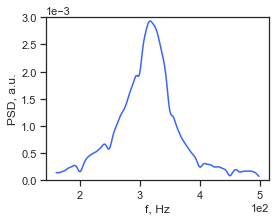

R2B-3B
max: 1.19
mean: 0.41
p: 0.50
std: 0.58


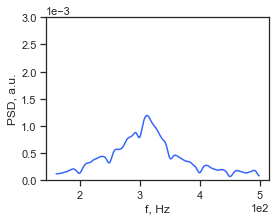

L4-3B
max: 0.41
mean: 0.25
p: 0.25
std: 0.18


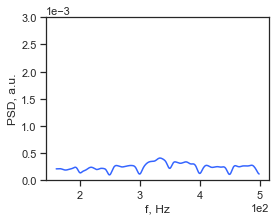

In [25]:
condition = "1Day ON Rest 180sec"
patient = p2

placements = ["R4-3C", "R2B-3B", "L4-3B"]

for placement in placements:
    
    lfp = patient.lfp[condition][placement]
    lfp_data = lfp.data.copy()
    lfp_data = lfp_data / np.std(lfp_data)

    lfp_norm = LFP(lfp_data, lfp.sf, lfp.patient_name, lfp.condition, lfp.placement)
    
    f, y = lfp_norm.get_psd(smooth=True, sigma=2)
    
    #y /= np.sum(y)

    mask = (f > 160) & (f < 500)
    
    f_hat, y_hat = f[mask], y[mask]
    y_hat -= np.min(y_hat)
    sigma=3
    y_hat = gaussian_filter1d(y_hat, sigma)
    p = 2
    
    print(placement)
    for power_type in ['max', 'mean', 'p', 'std']:
        power = get_power(y_hat, power_type, p)
        print(f"{power_type}: {power * 1e3:.2f}")
    
    plt.figure(figsize=(4, 3))
    plt.plot(f_hat, y_hat, alpha=0.8, label=placement)

    #lfp.show_psd(show_freqs=(50, 500))
    #plt.legend()
    plt.ylim((0, 0.003))
    plt.xlabel("f, Hz")
    plt.ylabel("PSD, a.u.")
    plt.ticklabel_format(style='sci', scilimits=(0, -3))
    with open("path_data.txt", 'r') as f:
        data_path = f.readline()
    
    plt.savefig(os.path.join(data_path, 'im_common', f'exampleHFO_{placement}.png'), dpi=150, bbox_inches='tight')
    plt.show()

#### Example Beta pictures

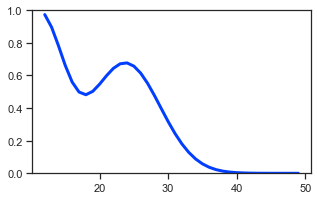

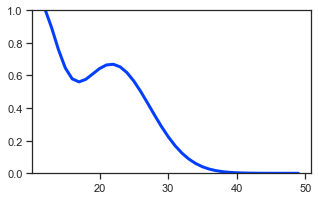

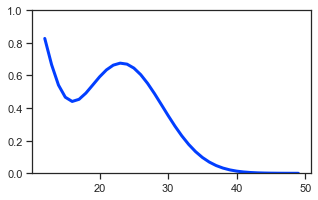

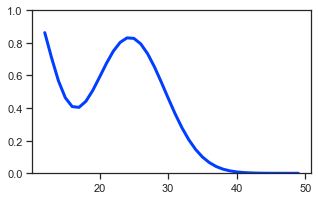

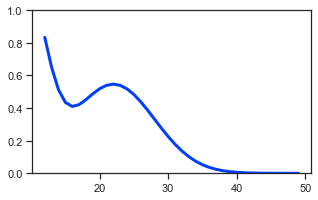

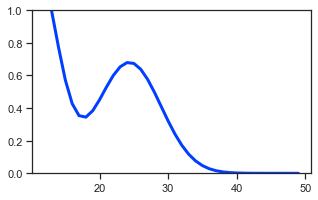

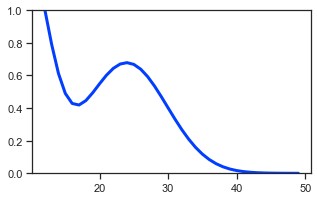

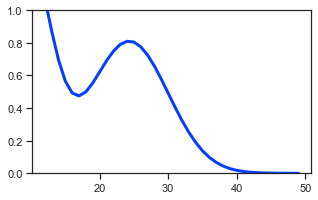

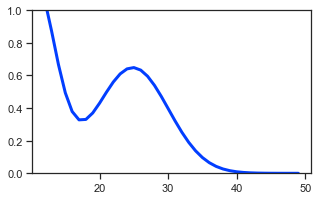

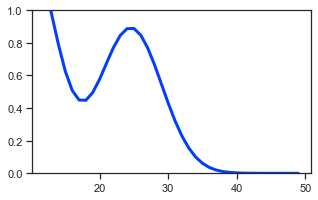

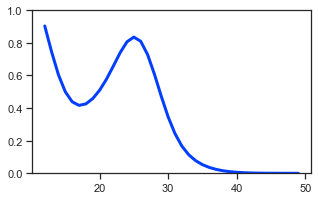

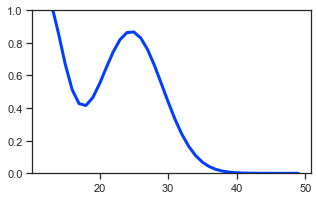

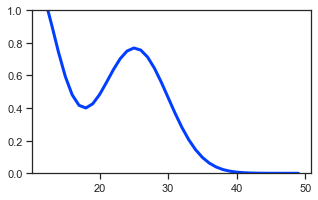

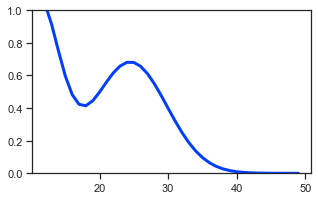

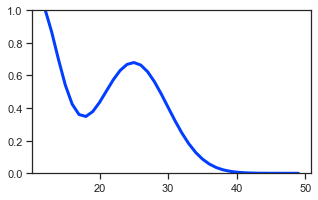

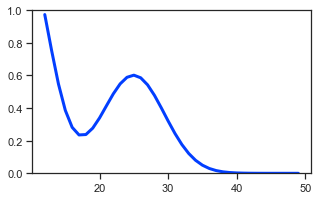

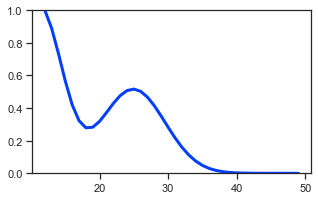

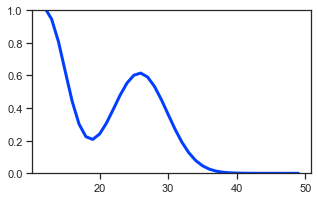

In [52]:
condition = "1Day OFF Rest 180sec"
patient = p2

cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                            "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]
placements = cross_placements

freqs = (12, 50)

for placement in placements:
    
    lfp = patient.lfp[condition][placement] 
    
    lfp_data = lfp.data.copy()
    lfp_data = lfp_data / np.std(lfp_data)
    lfp_norm = LFP(lfp_data, lfp.sf, lfp.patient_name, lfp.condition, lfp.placement)

    # getting PSD between 2 to 50 Hz
    f, psd = lfp_norm.get_psd()

    mask1= (f >= 2) & (f < 50)

    # getting FOOOF peak fit (without aperiodic component)
    fm = FOOOF(peak_width_limits=(1, 12), max_n_peaks=4, peak_threshold=1, verbose=False)
    fm.fit(f[mask1], psd[mask1])
    y_hat = fm._peak_fit

    # applying only to desired freq range (10 - 35) by default
    f0, f1 = freqs
    final_mask = (f[mask1] >= f0) & (f[mask1] <= f1)
    plt.figure(figsize=(5, 3))
    plt.plot(f[mask1][final_mask], y_hat[final_mask], linewidth=3)
    plt.ylim((0, 1))
    plt.savefig(os.path.join(data_path, 'im_common', f'exampleBETA_{placement}.png'), dpi=150, bbox_inches='tight')
    plt.close()

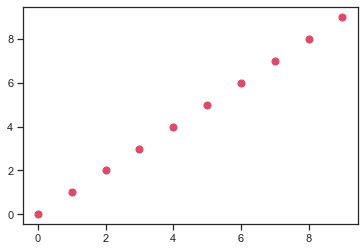

In [264]:
plt.scatter(np.arange(10), np.arange(10), s=50, color=sns.color_palette("magma", as_cmap=True)(0.6))

#### Calculating node colors for graph

In [339]:
def get_power_values(patient, verbose=True):
    """
    Calculates power on one patient. 
    Returns to dictionaries with condition as key
    Values: list of power values corresponding to each electrode location
    beta_powers: dict, hfo_powers: dict
    """
    cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                        "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]
    
    if verbose: print(f"Estimating spectral power for {patient.name}")
    
    n = len(cross_placements)
    
    conditions = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec", "5Day OFF Rest 180sec", "5Day ON Rest 180sec"]
    
    beta_powers = {cond:[] for cond in conditions if cond in patient.conditions} # condition -> list of powers corresponding to the cross_placement
    hfo_powers = {cond:[] for cond in conditions if cond in patient.conditions}
    
    for condition in beta_powers.keys():
        if "Rest 180sec" not in condition:
            continue
        if verbose: print(condition)
        iterable = enumerate(cross_placements)
        if verbose: iterable = tqdm(enumerate(cross_placements))
        for i, placement in iterable:
            lfp = patient.lfp[condition][placement]
            beta_powers[condition].append(get_beta_power(lfp))
            hfo_powers[condition].append(get_hfo_power(lfp))
            
    return beta_powers, hfo_powers


def get_power_margins(beta_powers, hfo_powers):
    """
    Input: dict of power values of a single patient
    Output: margins: (b1, b2), (h1, h2)
    """
    beta_powers_total = []
    hfo_powers_total = []
    for key in beta_powers.keys():
        beta_powers_total.append(beta_powers[key])
        hfo_powers_total.append(hfo_powers[key])
    
    b1, b2 = np.min(beta_powers_total), np.max(beta_powers_total)
    h1, h2 = np.min(hfo_powers_total), np.max(hfo_powers_total)
    
    return (b1, b2), (h1, h2)


def get_global_power_margins(margins_list):
    bmin, bmax = +np.inf, 0
    hmin, hmax = +np.inf, 0
    for margins in margins_list:
        (b1, b2), (h1, h2) = margins
        if b1 < bmin:
            bmin = b1
        if b2 > bmax:
            bmax = b2
        if h1 < hmin:
            hmin = h1
        if h2 > hmax:
            hmax = h2
    return (bmin, bmax), (hmin, hmax)


def get_node_colors(patient, 
                    condition, 
                    beta_powers, 
                    hfo_powers, 
                    power_margins, 
                    palette=sns.color_palette("magma", as_cmap=True)):
    """
    power_margins: ((b1, b2), (h1, h2))
    """
    # 1. acquire powers
    # 2. convert them to 0 - 1 values using provided margins
    # 3. use color palette to map [0, 1] -> color
    cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                        "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]
    
    n = len(cross_placements)
    
    (b1, b2), (h1, h2) = power_margins
    
    colors_left = [0 for _ in range(n)]
    colors_right = [0 for _ in range(n)]
    
    for i, placement in enumerate(cross_placements):
        
        beta_power = beta_powers[condition][i]
        hfo_power = hfo_powers[condition][i]
        
        beta_norm = (beta_power - b1)/(b2 - b1)
        hfo_norm = (hfo_power - h1)/(h2 - h1)
        
        colors_left[i] = palette(beta_norm)
        colors_right[i] = palette(hfo_norm)
        
    return colors_left + colors_right
        
        
    

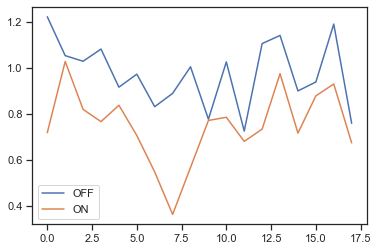

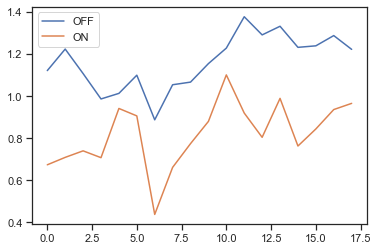

In [300]:
margins

((0.3620405966483572, 1.3775200424066616),
 (0.3620405966483572, 1.3775200424066616))

In [303]:
%%time

patient = p3

beta_powers, hfo_powers = get_power_values(patient)

Estimating spectral power for Patient3
1Day OFF Rest 180sec


0it [00:00, ?it/s]

1Day ON Rest 180sec


0it [00:00, ?it/s]

5Day OFF Rest 180sec


0it [00:00, ?it/s]

5Day ON Rest 180sec


0it [00:00, ?it/s]

Wall time: 8.07 s


In [304]:
margins = get_power_margins(beta_powers, hfo_powers)
margins

((0.3620405966483572, 1.3775200424066616),
 (5.634727839652548e-05, 0.0014629839643972116))

In [311]:
(a, b), (c, d) = power_margins

c

5.634727839652548e-05

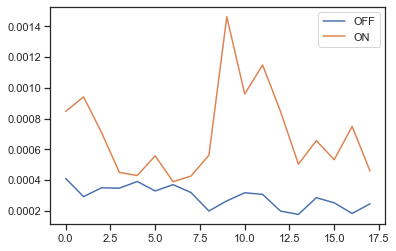

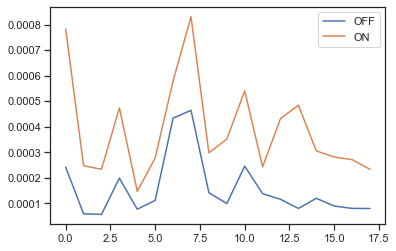

In [305]:
for day in [1, 5]:
    for ldopa in ["OFF", "ON"]:
        plt.plot(hfo_powers[f'{day}Day {ldopa} Rest 180sec'], label=ldopa)
    plt.legend()
    plt.show()

#### Test color mapping on graph

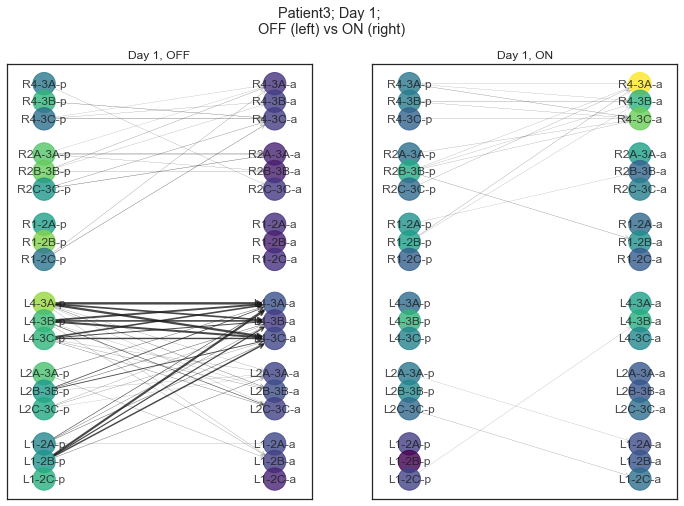

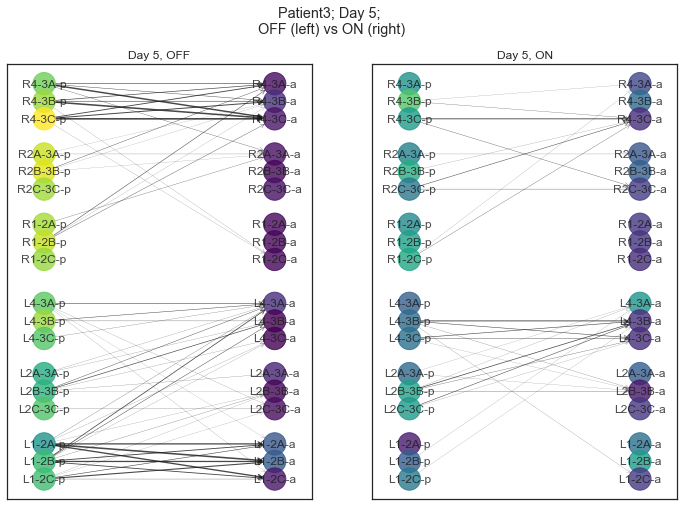

Wall time: 1.61 s


In [319]:
%%time

patient = p3

beta_powers, hfo_powers = get_power_values(patient)
power_margins = get_power_margins(beta_powers, hfo_powers)

days = [1, 5]
for j in range(len(days)):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    conditions = [f"{days[j]}Day OFF Rest 180sec", f"{days[j]}Day ON Rest 180sec"]
    for i, condition in enumerate(conditions):
        ax = axes[i]
        G = get_bigraph(patient, condition, norm_threshold=norm_threshold)

        colors = get_node_colors(patient, condition, beta_powers, hfo_powers, power_margins, palette=sns.color_palette("viridis", as_cmap=True))
        draw_bigraph(G, ax=ax, colors=colors)
        day, ldopa, movement = retrieve_condition_name(condition)
        ax.set_title(f"Day {days[j]}, {ldopa}")

    plt.suptitle(f"{patient.name}; Day {days[j]}; \nOFF (left) vs ON (right)");
    #fig_name = f"Bigraph; {patient.name}; Day {days[j]}; OFF vs ON.png"
    #fig_path = os.path.join(save_path, fig_name)
    #plt.savefig(fig_path)
    plt.show()

#### Draw BiGraph

In [12]:
def draw_bigraph(G, ax, colors=None):
    cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                        "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]
    n = len(cross_placements)
    # get node names
    nodes_left = [node + '-p' for node in cross_placements]
    nodes_right = [node + '-a' for node in cross_placements]
    
    # get node positions
    y2 = np.array([0.1, 0.18, 0.26, 0.42, 0.5, 0.58, 0.74, 0.82, 0.9])[::-1]
    y1 = -y2[::-1]
    pos_y = np.concatenate((y1, y2)).reshape(-1, 1)
    #pos_y = np.concatenate((- np.linspace(-0.85, -0.1, n // 2), - np.linspace(0.1, 0.85, n // 2))).reshape(-1, 1)
    pos_left = np.hstack((-0.5 * np.ones((n, 1)), pos_y))
    pos_right = np.hstack((0.5 * np.ones((n, 1)), pos_y)) 

    positions_left = {node:position for node, position in zip(nodes_left, pos_left)}
    positions_right = {node:position for node, position in zip(nodes_right, pos_right)}

    pos = {**positions_left, **positions_right}
    
    weights = np.array([G[u][v]['weight'] for u,v in G.edges()])
    
    if colors is None:
        aquamarine = np.array([127, 125, 212]) / 256
        goldenrod = np.array([255, 193, 37]) / 256
        colors = (aquamarine, goldenrod)
        node_color = [colors[0] for _ in range(n)] + [colors[1] for _ in range(n)]
        
    else:
        node_color=colors

    nx.draw_networkx(G, 
                     ax=ax,
                     pos=pos, 
                     arrows=True, 
                     arrowstyle='->', 
                     width=weights / 8, 
                     node_size=500, 
                     node_color=node_color, alpha=0.8)
    
    ax.margins(0.1, 0)

### Day 5 OFF vs ON

## Computing matrix norm

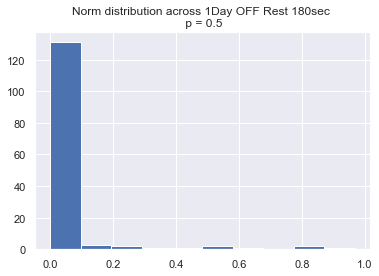

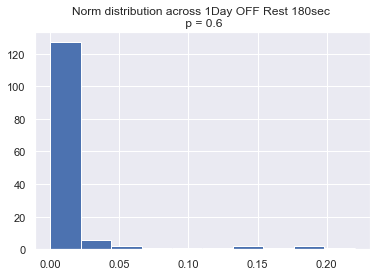

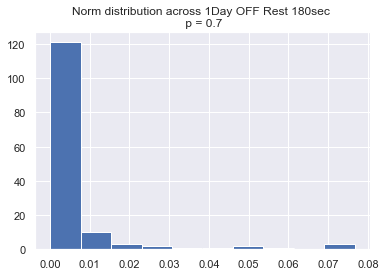

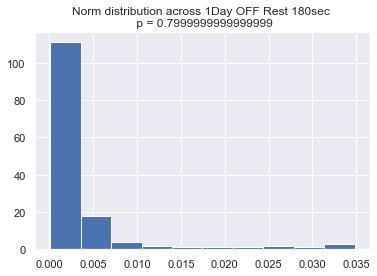

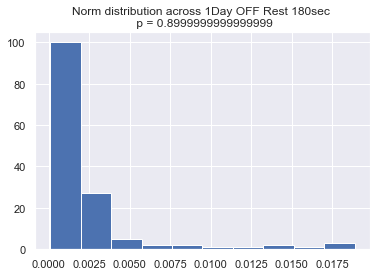

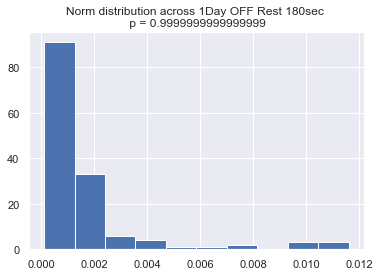

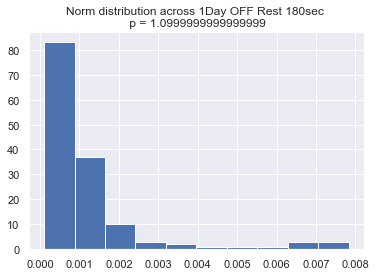

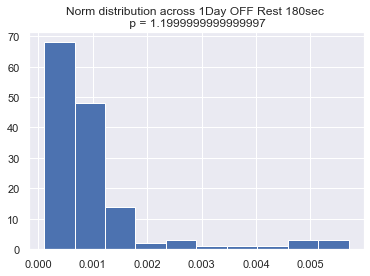

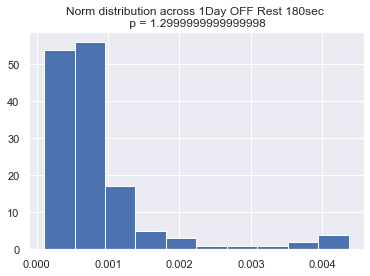

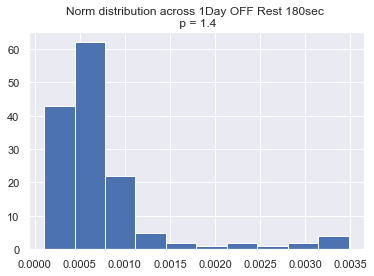

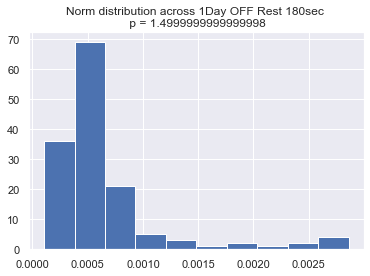

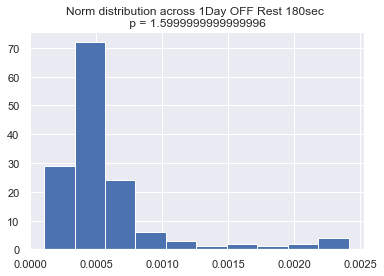

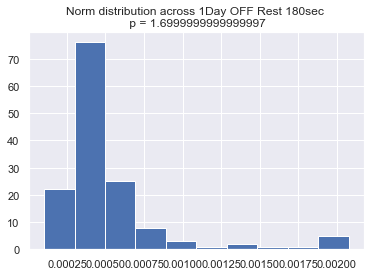

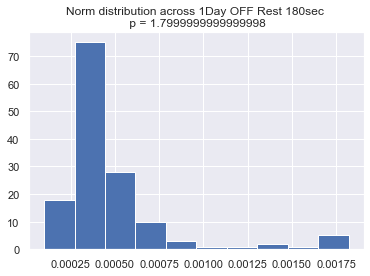

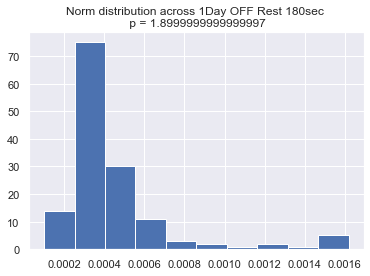

In [95]:

patient = p3
condition = "1Day OFF Rest 180sec" # OFF
placements = patient.sorted_placements

for p in np.arange(0.5, 2., 0.1):
    norms = []
    for pi, pj in combinations(placements, 2):


        if not pac_exists(patient, condition, pi, pj):
                continue
        if not pac_exists(patient, condition, pj, pi):
                continue

    #pi, pj = "R1-2C", "R4-3B"
        pac = patient.pac[condition][pi][pj]
        sig_pac = get_sig_pac(pac, mask_lonely=False)
        norm = compute_matrix_norm(sig_pac, 'p', p)
        #print(f"{pi}->{pj}: {norm * 1e4:.1f}")
        norms.append(norm)
        pac = patient.pac[condition][pj][pi]
        sig_pac = get_sig_pac(pac, mask_lonely=False)
        norm = compute_matrix_norm(sig_pac, 'p', p)
        #print(f"{pj}->{pi}: {norm * 1e4:.1f}")
        norms.append(norm)
    plt.title(f"Norm distribution across {condition} \n p = {p}")
    plt.hist(norms)
    plt.show()

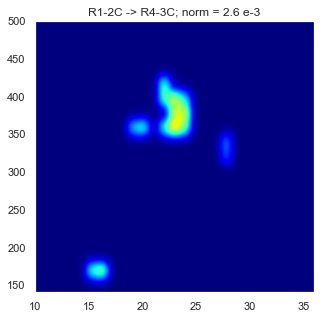

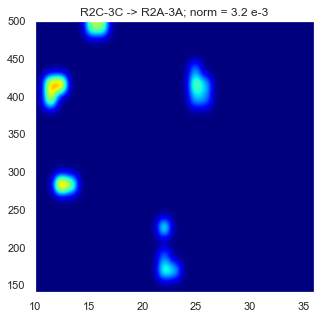

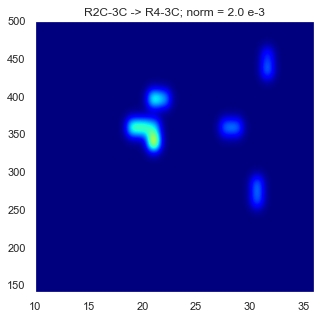

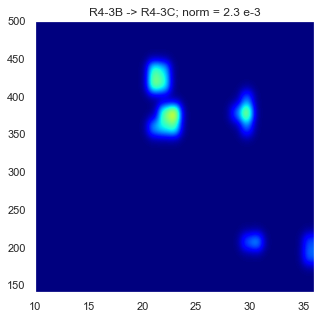

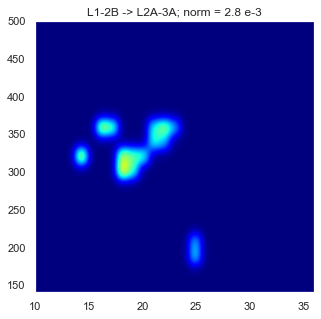

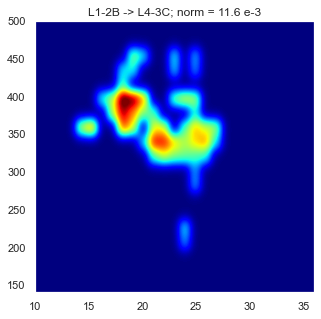

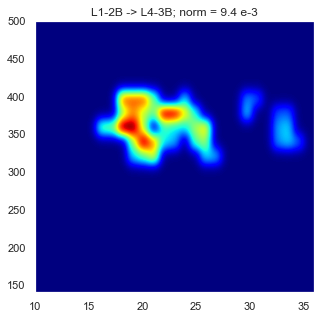

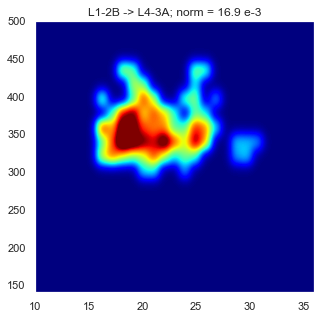

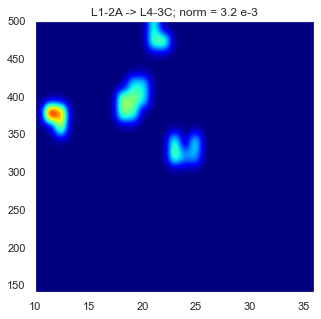

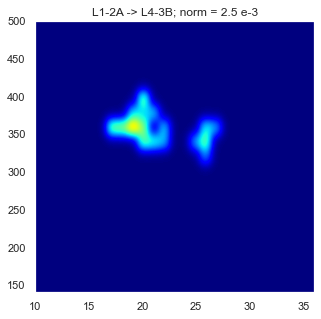

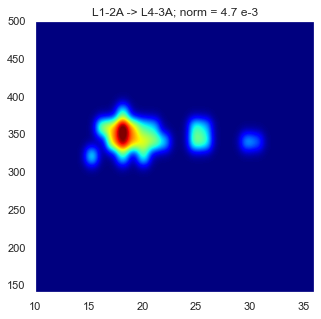

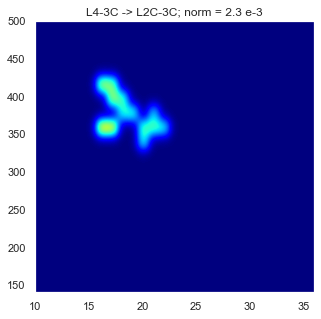

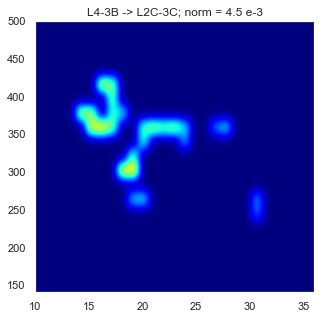

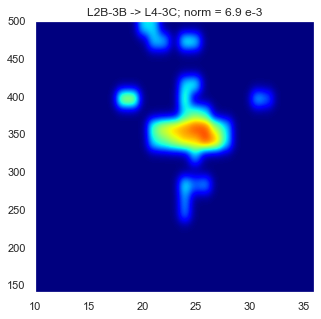

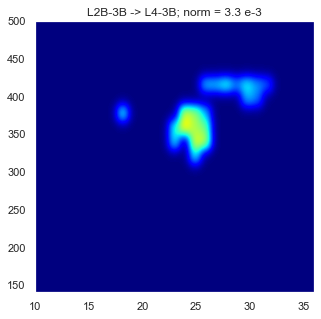

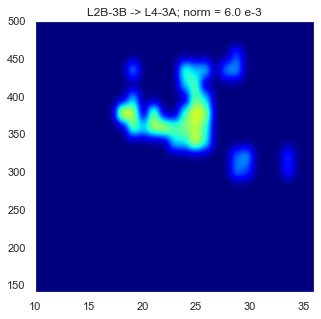

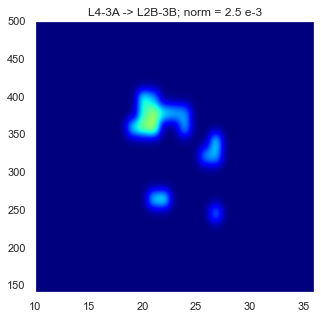

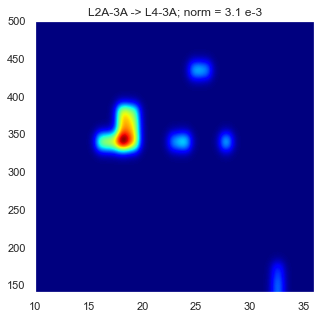

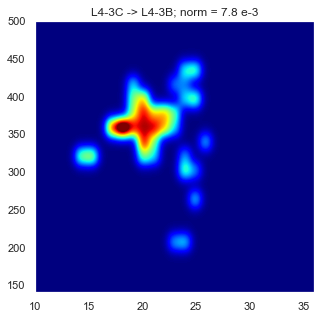

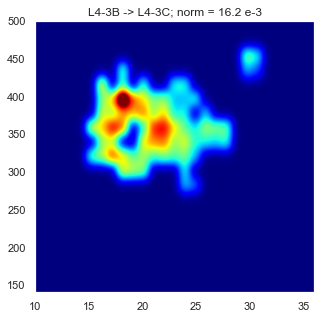

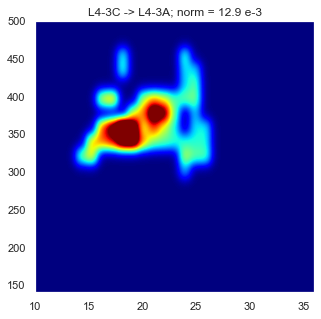

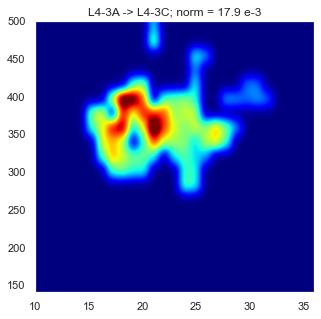

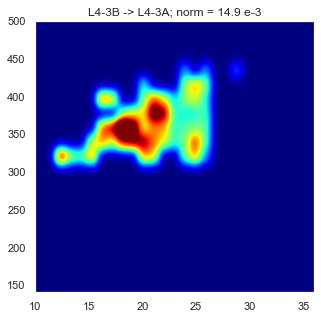

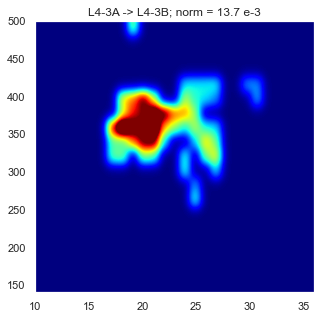

In [98]:
p = 0.9
threshold = 2e-3

for pi, pj in combinations(placements, 2):
    
        if not pac_exists(patient, condition, pi, pj):
                continue
        if not pac_exists(patient, condition, pj, pi):
                continue
        for pp, pa in [(pi, pj), (pj, pi)]:
            pac = patient.pac[condition][pp][pa]
            sig_pac = get_sig_pac(pac, mask_lonely=True)
            norm = compute_matrix_norm(sig_pac, 'p', p)
            if norm > threshold:
                plt.figure(figsize=(5, 5))
                plt.title(f"{pp} -> {pa}; norm = {norm * 1000:.1f} e-3")
                comodulogram(sig_pac, pac.beta_params, pac.hfo_params, pac.pvalues, significant=True, vmax=0.00025)
                plt.grid()
                plt.show()

## Norms

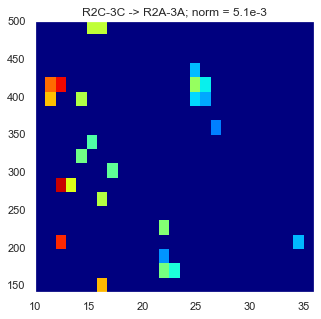

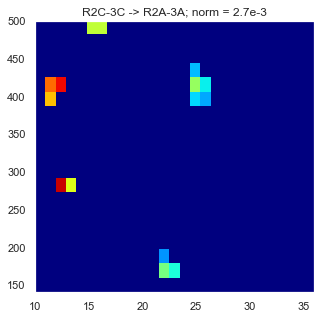

In [99]:
pp, pa = "R2C-3C", "R2A-3A"

pac = patient.pac[condition][pp][pa]

sig_pac = pac.pac_matrix.copy()
sig_pac[pac.pvalues > 0.01] = 0

norm = compute_matrix_norm(sig_pac, 'p', p)
plt.figure(figsize=(5, 5))
plt.title(f"{pp} -> {pa}; norm = {norm * 1000:.1f}e-3")
comodulogram(pac.pac_matrix, pac.beta_params, pac.hfo_params, pac.pvalues, significant=True, vmax=0.00025, smooth=False)
plt.grid()
plt.show()

sig_pac = pac.pac_matrix.copy()
sig_pac[pac.pvalues > 0.01] = 0
sig_pac = mask_nonclustered(sig_pac)

norm = compute_matrix_norm(sig_pac, 'p', p)

plt.figure(figsize=(5, 5))
plt.title(f"{pp} -> {pa}; norm = {norm * 1000:.1f}e-3")
comodulogram(sig_pac, pac.beta_params, pac.hfo_params, pac.pvalues, significant=True, vmax=0.00025, smooth=False)
plt.grid()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1)
ax.plot(np.arange(5))
ax.colorbar()

NameError: name 'mask_nonclustered' is not defined

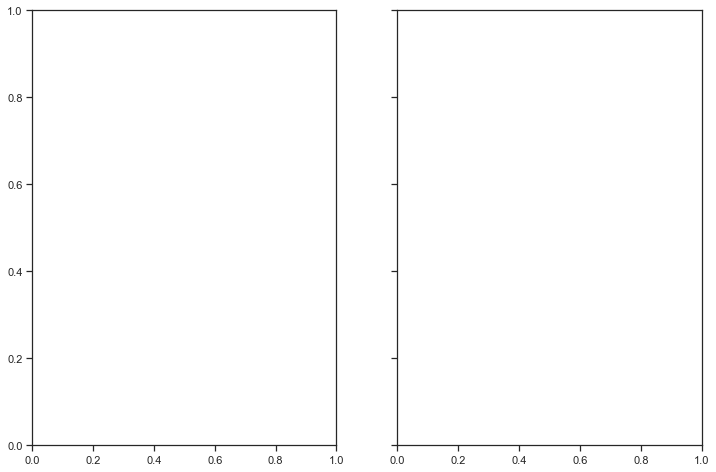

In [47]:
patient = p3


norm_threshold = 2
days = [1, 5]
for j in range(len(days)):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    conditions = [f"{days[j]}Day OFF Rest 180sec", f"{days[j]}Day ON Rest 180sec"]
    for i, condition in enumerate(conditions):
        ax = axes[i]
        G = get_bigraph(patient, condition, norm_threshold=norm_threshold)
        
        draw_bigraph(G, ax=ax)
        day, ldopa, movement = retrieve_condition_name(condition)
        ax.set_title(f"Day {days[j]}, {ldopa}")

    plt.suptitle(f"{patient.name}; Day {days[j]}; \nOFF (left) vs ON (right)");
    #fig_name = f"Bigraph; {patient.name}; Day {days[j]}; OFF vs ON.png"
    #fig_path = os.path.join(save_path, fig_name)
    #plt.savefig(fig_path)
    plt.show()

## Drawing bipartate graphs (all patients)

#### Coloring: getting beta and HFO power values + margins

In [9]:
patients = [p9]
beta_powers_list = []
hfo_powers_list = []
margins_list = []

for patient in patients:
    beta_powers, hfo_powers = get_power_values(patient, verbose=True)
    margins = get_power_margins(beta_powers, hfo_powers)
    
    beta_powers_list.append(beta_powers)
    hfo_powers_list.append(hfo_powers)
    margins_list.append(margins)
    
global_margins = get_global_power_margins(margins_list)

Estimating spectral power for Patient9
1Day OFF Rest 180sec


0it [00:00, ?it/s]

1Day ON Rest 180sec


0it [00:00, ?it/s]

5Day OFF Rest 180sec


0it [00:00, ?it/s]

5Day ON Rest 180sec


0it [00:00, ?it/s]

In [7]:
os.mkdir(save_path)

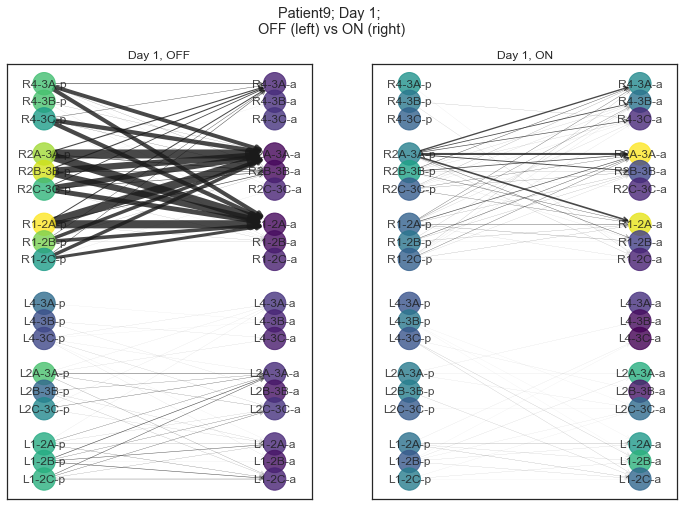

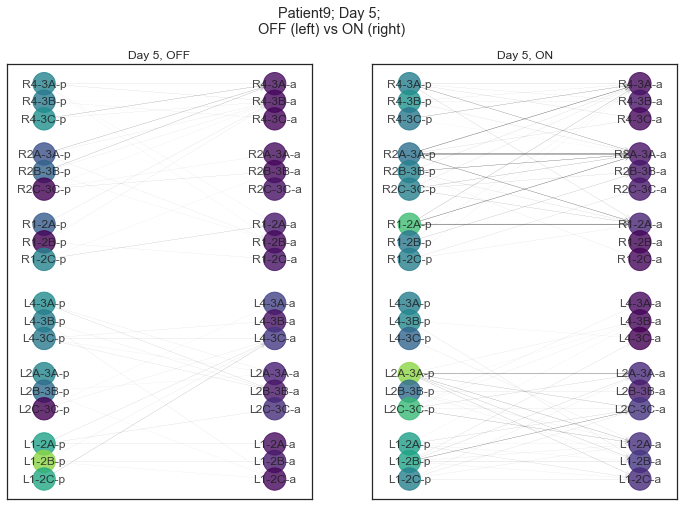

In [10]:
#p1 = load_patient(1)
sns.set_context('notebook')
sns.set_style('ticks')

with open('../path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'cross_pac_graphs')
try: 
    os.mkdir(save_path)
except:
    pass
patients = [p9]
for i, patient in enumerate(patients):
    beta_powers, hfo_powers = beta_powers_list[i], hfo_powers_list[i]
    power_margins = margins_list[i]

    days = [1, 5]
    for j in range(len(days)):
        fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
        conditions = [f"{days[j]}Day OFF Rest 180sec", f"{days[j]}Day ON Rest 180sec"]
        for i, condition in enumerate(conditions):
            if condition not in patient.conditions:
                continue
            ax = axes[i]
            G = get_bigraph(patient, condition, norm_threshold=0)

            colors = get_node_colors(patient, condition, beta_powers, hfo_powers, power_margins, palette=sns.color_palette("viridis", as_cmap=True))
            divider = 500 if patient.name == 'Patient8' else 8
            draw_bigraph(G, ax=ax, colors=colors, weight_divider=divider)
            day, ldopa, movement = retrieve_condition_name(condition)
            ax.set_title(f"Day {days[j]}, {ldopa}")

        plt.suptitle(f"{patient.name}; Day {days[j]}; \nOFF (left) vs ON (right)");
        fig_name = f"Bigraph-colored; {patient.name}; Day {days[j]}; OFF vs ON.png"
        fig_path = os.path.join(save_path, fig_name)
        plt.savefig(fig_path, dpi=200)
        plt.show()

## Global coloring

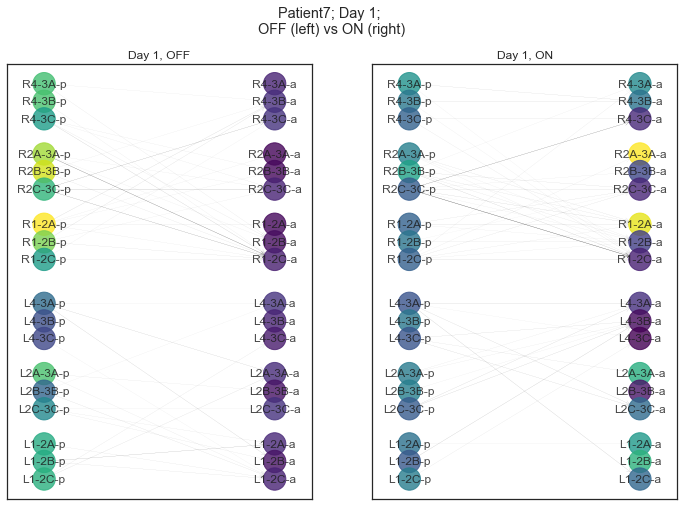

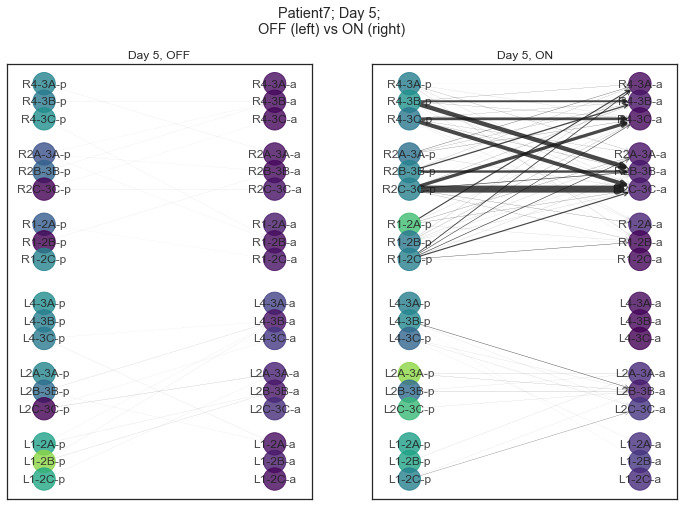

IndexError: list index out of range

In [6]:
sns.set_context('notebook')
sns.set_style('ticks')


save_path = os.path.join(data_path, 'im_common', 'cross_pac_graphs')

patients = [p7, p8, p9]
for i, patient in enumerate(patients):
    beta_powers, hfo_powers = beta_powers_list[i], hfo_powers_list[i]

    days = [1, 5]
    for j in range(len(days)):
        fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
        conditions = [f"{days[j]}Day OFF Rest 180sec", f"{days[j]}Day ON Rest 180sec"]
        for i, condition in enumerate(conditions):
            ax = axes[i]
            if condition not in patient.conditions:
                continue
            G = get_bigraph(patient, condition, norm_threshold=0)

            colors = get_node_colors(patient, condition, beta_powers, hfo_powers, global_margins, palette=sns.color_palette("viridis", as_cmap=True))
            draw_bigraph(G, ax=ax, colors=colors)
            day, ldopa, movement = retrieve_condition_name(condition)
            ax.set_title(f"Day {days[j]}, {ldopa}")

        plt.suptitle(f"{patient.name}; Day {days[j]}; \nOFF (left) vs ON (right)");
        fig_name = f"Bigraph-colored-global; {patient.name}; Day {days[j]}; OFF vs ON.png"
        fig_path = os.path.join(save_path, fig_name)
        plt.savefig(fig_path, dpi=200)
        plt.show()

Text(0.5, 0.98, 'Patient2; Day 1; OFF (left) vs ON (right)')

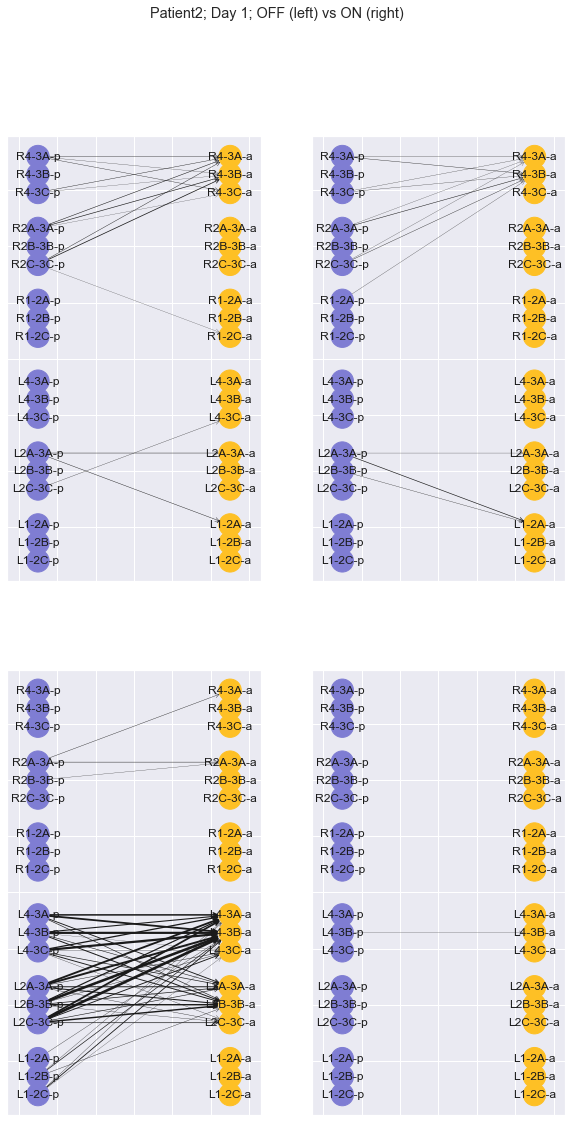

In [91]:
#p2 = load_patient(2)
patient = p2
conditions_1day = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]

norm_threshold = 2e-3

fig, axes = plt.subplots(2, 2, figsize=(10, 18), sharey=True)

for i, condition in enumerate(conditions_1day):
    G = get_bigraph(patient, condition, norm_threshold=norm_threshold)
    draw_bigraph(G, ax=axes[0, i])
    
conditions_5day = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

for i, condition in enumerate(conditions_5day):
    G = get_bigraph(patient, condition, norm_threshold=norm_threshold)
    draw_bigraph(G, ax=axes[1, i])
    
plt.suptitle(f"{patient.name}; Day 1; OFF (left) vs ON (right)")

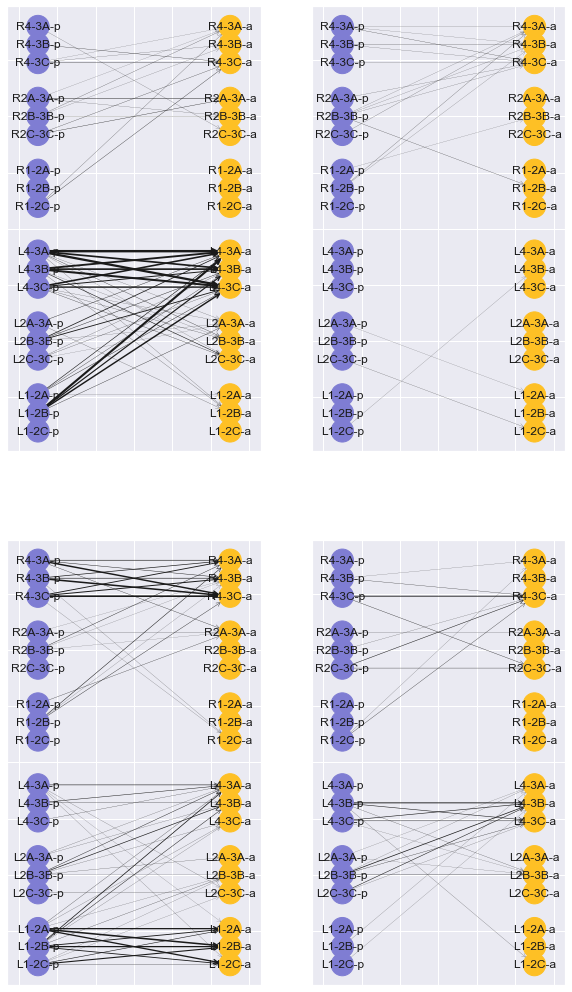

In [100]:
patient = p3
conditions_1day = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]

fig, axes = plt.subplots(2, 2, figsize=(10, 18), sharey=True)
norm_threshold = 1e-3


for i, condition in enumerate(conditions_1day):
    G = get_bigraph(patient, condition, norm_threshold=norm_threshold)
    draw_bigraph(G, ax=axes[0, i])
    
conditions_5day = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]


for i, condition in enumerate(conditions_5day):
    G = get_bigraph(patient, condition, norm_threshold=norm_threshold)
    draw_bigraph(G, ax=axes[1, i])

Patient directory:  D:\LAB\AlexPAC\data\Patient5


Text(0.5, 0.98, 'Patient5; OFF (left) vs ON (right)')

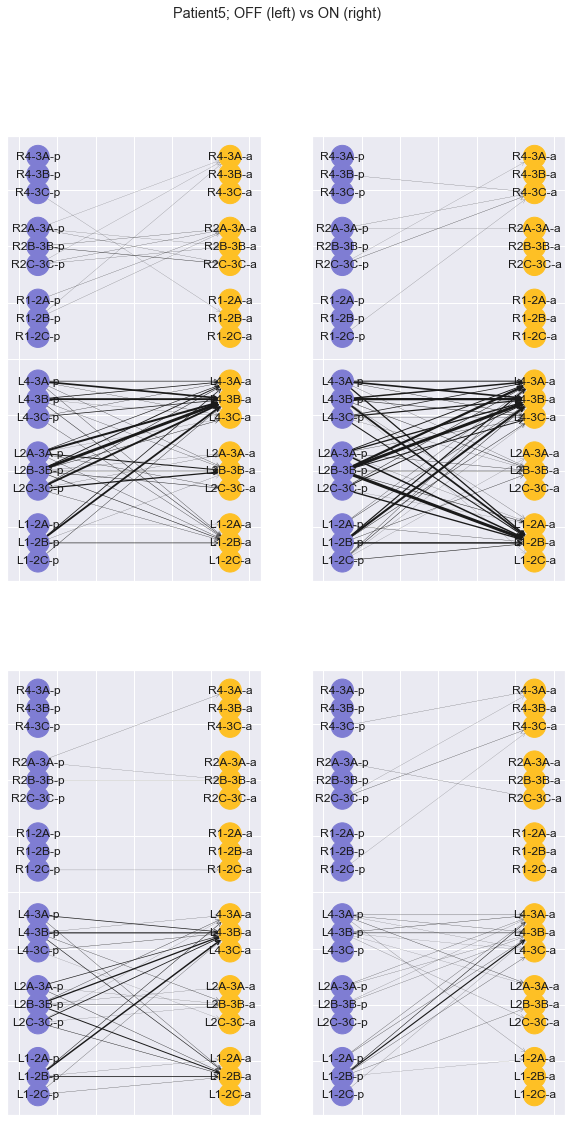

In [101]:
p5 = load_patient(5)
patient = p5
conditions_1day = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]

fig, axes = plt.subplots(2, 2, figsize=(10, 18), sharey=True)

for i, condition in enumerate(conditions_1day):
    G = get_bigraph(patient, condition, norm_threshold=norm_threshold)
    draw_bigraph(G, ax=axes[0, i])
    
conditions_5day = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

for i, condition in enumerate(conditions_5day):
    G = get_bigraph(patient, condition, norm_threshold=norm_threshold)
    draw_bigraph(G, ax=axes[1, i])
    
plt.suptitle(f"{patient.name}; OFF (left) vs ON (right)")

Patient directory:  D:\LAB\AlexPAC\data\Patient6


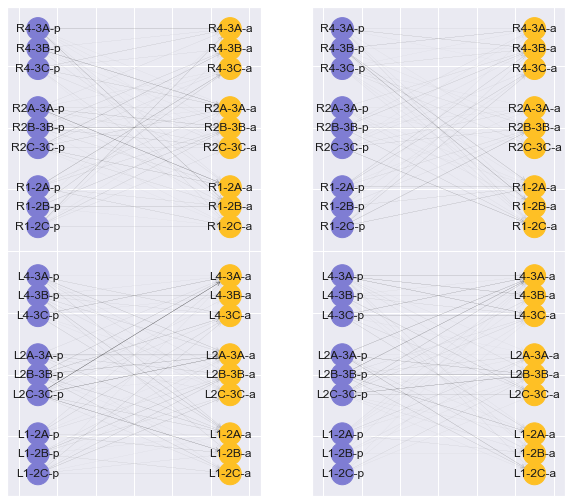

In [102]:
p6 = load_patient(6)
patient = p6
conditions_1day = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec"]

fig, axes = plt.subplots(1, 2, figsize=(10, 9), sharey=True)

for i, condition in enumerate(conditions_1day):
    G = get_bigraph(patient, condition, norm_threshold=0)
    draw_bigraph(G, ax=axes[i])
    
# conditions_5day = ["5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

# for i, condition in enumerate(conditions_5day):
#     G = get_bigraph(patient, condition, norm_threshold=norm_threshold)
#     draw_bigraph(G, ax=axes[1, i])
    
# plt.suptitle(f"{patient.name}; Day 1; OFF (left) vs ON (right)")